### Summary of this notebook
1. I ran the swapping kempe chains code provided by professor.
2. Starting from the previous feasible solution, I implement partial k coloring method. And, to avoid stucking in the local optimum, I randomly uncolored some nodes in each iteration.
3. the result of partial k coloring shows that the solution from swapping kempe chains might be the global optimum. Otherwise, the we should allow partial k coloring to do more searching iteration.

In [1]:
import time
import copy
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm

from pylab import rcParams
rcParams['figure.figsize'] = 20, 15

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
with open(os.getcwd() + '/graph-to-color.txt', 'r') as f:
    data = f.readlines()
edges = [(int(d.split(',')[0]), int(d.split(', ')[1].split(')')[0])) for d in data[0].split('(')[1:]]
print(len(edges))

355


In [3]:
edges[:10]

[(0, 2),
 (0, 5),
 (0, 8),
 (1, 2),
 (1, 3),
 (1, 7),
 (2, 4),
 (2, 6),
 (5, 3),
 (5, 6)]

In [4]:
def getPositions(G):
    return [tuple(i[1].values()) for i in G.nodes.data()]

def getLabels(G):
    return [i[0] for i in G.nodes.data()]

In [5]:
def graph_coloring_local(G, coloring=None):
    #initialize all nodes a different color
    n = G.number_of_nodes()
    
    if not coloring:
        coloring = {}
        for i in range(0, n):
            coloring[i] = i
            
    
    #assign random coordinates to nodes in G for printing
    pos = getPositions(G)
    lab = getLabels(G)


    local_opt = True
    while local_opt:
        
        colors = list(coloring.values())
        to_break = False

        for c, j in itertools.product(colors, colors):

            if j > c:
                subgraph_nodes_c = []
                subgraph_nodes_j = []

                for node in coloring.keys():
                #all nodes colored c
                    if coloring[node] == c:
                        subgraph_nodes_c.append(node)
                    #all nodes colored j
                    elif coloring[node] == j:
                        subgraph_nodes_j.append(node)

                # form subgraph with those 2 colors
                G1 = nx.Graph()
                G1 = G.subgraph(subgraph_nodes_c + subgraph_nodes_j)
                # no connected components (ie no edges), change color of j to c
                if G1.number_of_edges() == 0:
                    for k in subgraph_nodes_j:
                        coloring[k] = c
                    # print when a color is eliminated
                    values = [coloring.get(node, 0.25) for node in G.nodes()]
                    
                    # improvement found, update coloring and find new pair of colorings to swap
                    to_break = True 

                    # nx.draw(G, pos = pos, node_color = values, with_labels=True, font_color = 'white')
                    # plt.show()
                else:
                    #set of nodes for each connected components
                    comps = list(nx.connected_components(G1))

                    # initial function value -(|c|^2+|j|^2)
                    c_size = len(subgraph_nodes_c)
                    j_size = len(subgraph_nodes_j)
                    v_int = -(c_size**2 + j_size**2)
                    
                    
                    for l in comps:
                    # changed function value
                        l = list(l)
                        c_swap = list(set(subgraph_nodes_c) & set(l))
                        j_swap = list(set(subgraph_nodes_j) & set(l))
                        v_change = -((c_size + len(j_swap) - len(c_swap))**2 + (j_size + len(c_swap) - len(j_swap))**2)
                        if v_change < v_int:
                            for k in c_swap:
                                coloring[k] = j
                            for k in j_swap:
                                coloring[k] = c
                            break
                            
                            # improvement found, update coloring and find new pair of colorings to swap
                            to_break = True
                            
                if to_break:
                    break

        # at end of for loop no swaps happen
        if not to_break:
            # if ever all pairs of colors checked without breaking, local minimum; stop algorithm
            local_opt = False


    values = [coloring.get(node, 0.25) for node in G.nodes()]
    num = len(set(coloring.values()))
    print("the feasible coloring is: ", set(coloring.values()))
    print("number of colors used =", num)
    nx.draw(G, pos=pos, node_color=values, with_labels=True, font_color='white')
    plt.show()

    return coloring

In [6]:
graph = nx.Graph()
graph.add_edges_from(edges)
n = graph.number_of_nodes()
for index in range(n):
    graph.add_node(
        index, 
        x=np.random.uniform(), 
        y=np.random.uniform()
    )

the feasible coloring is:  {0, 2, 35, 5}
number of colors used = 4


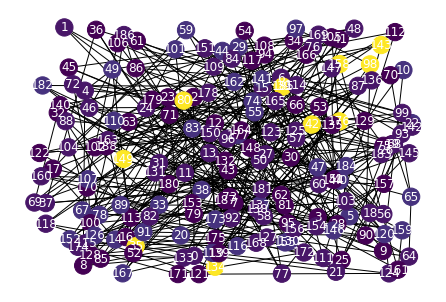

In [7]:
result = graph_coloring_local(graph)

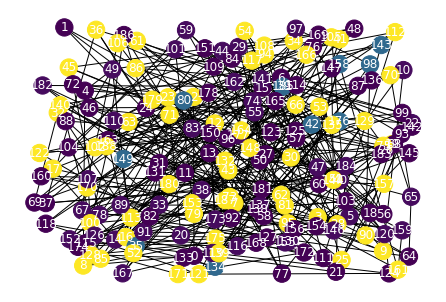

In [8]:
changeColorMap = [100 if result.get(node)==0 else result.get(node) for node in graph.nodes()]

nx.draw(
    graph, 
    pos=getPositions(graph), 
    node_color=changeColorMap, 
    with_labels=True, 
    font_color='white'
)

In [9]:
list(result.items())[:10]

[(0, 2),
 (1, 2),
 (2, 0),
 (3, 0),
 (4, 2),
 (5, 5),
 (6, 2),
 (7, 0),
 (8, 0),
 (9, 0)]

In [10]:
color_counts = pd.Series(result).value_counts()
color_counts

2     70
0     67
5     42
35    10
dtype: int64

### Partial K-colorings

try to implement partial k-coloring for local search in graph coloring problem

to avoid stucking in the local optimum, I add the rand_color which randomly assigns nodes to be uncolored in each iteration. 

The number of uncolored nodes will be deminished as the searching iteration increases so as to make the algorithm converge

In [21]:
def kPartialColoring(graph, partialColor, kColorList, seed=1234, i=50, maxIter=10000, rand_uncolor=True):
    np.random.seed(seed)
    contAllLoop = True
    iteration = 0


    pbar = tqdm(total=maxIter)
    while contAllLoop and iteration < maxIter:

        if rand_uncolor:
            # Randomly remove colored nodes into uncolored
            randNum = np.random.randint(max(i, 10))
            for i in np.random.randint(188, size=randNum):
                partialColor[i] = None


        # List all uncolored nodes
        uncoloredList = []
        for n, c in partialColor.items():
            if c is None:
                uncoloredList.append(n)


        if len(set(partialColor.values())) != 4:
            contAllLoop = False
            break


        while len(uncoloredList) > 0:
            n = uncoloredList.pop(0)
            
            colorMap = {}
            for kc in kColorList:
                colorMap[kc] = []
            for neighbor in list(graph.neighbors(n)):
                if partialColor.get(neighbor) is not None:
                    colorMap[ partialColor.get(neighbor) ].append(neighbor)


            degree = graph.degree(n)
            moveOnList = []
            for c, nodeList in colorMap.items():
                if degree >= sum([d for _, d in list(graph.degree(nodeList))]):
                    degree = sum([d for _, d in list(graph.degree(nodeList))])
                    moveOnList.extend(nodeList)


            colorSet = set()
            for c, vList in colorMap.items():
                if len(vList) == 0:
                    colorSet.add(c)

            if len(colorSet) < 3 and len(colorSet) > 0:
                partialColor[n] = list(set(kColorList).intersection(colorSet))[-1]

                if all(v is not None for _, v in partialColor.items()):
                    contAllLoop = False
                    break
                # print('-'*10, 'fill in a color without iteration!!', '-'*10, '\n')
                continue


            uncoloredList.extend(moveOnList)
        

        i -= 1
        iteration += 1
        pbar.update(1)

    pbar.close()
    
    return partialColor

### Try Example on Lecture 5

In [13]:
ex_graph = nx.Graph()
ex_graph.add_edges_from([(1,2), (1,3), (2,3), (2,4), (2,5), (2,6), (4,5)])
n = ex_graph.number_of_nodes()
position = {
    0: (1,3),
    1: (2,3),
    2: (2,2),
    3: (3,2),
    4: (1,1),
    5: (2,1),
    6: (3,1),
}
for index in range(n+1):
    ex_graph.add_node(
        index, 
        x=position.get(index)[0], 
        y=position.get(index)[1]
    )

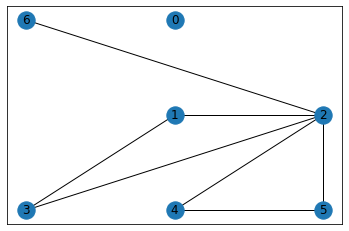

In [14]:
nx.draw_networkx(ex_graph, pos=getPositions(ex_graph))

In [15]:
partialColor = {
    0: 1,
    1: 1,
    2: None,
    3: 2,
    4: 5,
    5: 1,
    6: 5,
}

In [16]:
ex_result = kPartialColoring(ex_graph, partialColor, [1,2,5], rand_uncolor=False)

  0%|          | 2/10000 [00:00<00:23, 424.33it/s]


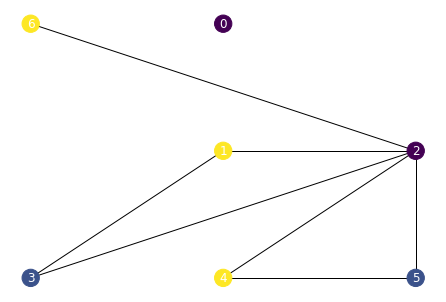

In [17]:
nx.draw(
    ex_graph, 
    pos=getPositions(ex_graph), 
    node_color=[partialColor.get(n) for n in ex_graph.nodes()], 
    with_labels=True, 
    font_color='white'
)

In [23]:
partialColor = copy.deepcopy(result)

for k, v in partialColor.items():
    if v == color_counts.index[-1]:
        partialColor[k] = None
    
    # change color `0` into `1` just in case some if statement fail
    if v == 0:
        partialColor[k] = 1

In [24]:
kpartial_result = kPartialColoring(
    graph, 
    partialColor, 
    [1,2,5], 
    seed=1234, i=50, maxIter=10000, rand_uncolor=True
)



  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 21/10000 [00:00<00:48, 205.25it/s]

  0%|          | 37/10000 [00:00<00:52, 188.74it/s]

  1%|          | 54/10000 [00:00<00:54, 182.56it/s]

  1%|          | 73/10000 [00:00<00:54, 182.85it/s]

  1%|          | 93/10000 [00:00<00:53, 186.09it/s]

  1%|          | 111/10000 [00:00<00:53, 183.64it/s]

  1%|▏         | 128/10000 [00:00<00:58, 168.26it/s]

  1%|▏         | 144/10000 [00:00<01:01, 161.20it/s]

  2%|▏         | 164/10000 [00:00<00:57, 169.63it/s]

  2%|▏         | 181/10000 [00:01<00:59, 164.84it/s]

  2%|▏         | 198/10000 [00:01<00:59, 163.40it/s]

  2%|▏         | 215/10000 [00:01<01:07, 143.95it/s]

  2%|▏         | 230/10000 [00:01<01:07, 145.07it/s]

  2%|▎         | 250/10000 [00:01<01:01, 158.04it/s]

  3%|▎         | 271/10000 [00:01<00:57, 170.68it/s]

  3%|▎         | 289/10000 [00:01<01:03, 153.75it/s]

  3%|▎         | 306/10000 [00:01<01:01, 158.00it/s]

  3%|▎         | 323/10000 [00:01<01:00, 1

 22%|██▏       | 2245/10000 [00:16<00:45, 169.43it/s]

 23%|██▎       | 2263/10000 [00:16<00:51, 149.55it/s]

 23%|██▎       | 2279/10000 [00:16<00:54, 142.40it/s]

 23%|██▎       | 2294/10000 [00:16<00:59, 129.01it/s]

 23%|██▎       | 2308/10000 [00:16<01:09, 110.40it/s]

 23%|██▎       | 2321/10000 [00:17<01:09, 110.72it/s]

 24%|██▎       | 2350/10000 [00:17<00:56, 135.72it/s]

 24%|██▎       | 2374/10000 [00:17<00:49, 154.98it/s]

 24%|██▍       | 2395/10000 [00:17<00:45, 167.01it/s]

 24%|██▍       | 2415/10000 [00:17<00:44, 171.81it/s]

 24%|██▍       | 2434/10000 [00:17<00:43, 175.32it/s]

 25%|██▍       | 2453/10000 [00:17<00:46, 163.89it/s]

 25%|██▍       | 2474/10000 [00:17<00:43, 174.94it/s]

 25%|██▍       | 2493/10000 [00:17<00:42, 178.44it/s]

 25%|██▌       | 2512/10000 [00:18<00:46, 160.49it/s]

 25%|██▌       | 2529/10000 [00:18<00:47, 158.06it/s]

 25%|██▌       | 2546/10000 [00:18<00:49, 150.68it/s]

 26%|██▌       | 2562/10000 [00:18<00:50, 148.44it/s]

 26%|██▌  

 46%|████▌     | 4582/10000 [00:32<00:33, 163.20it/s]

 46%|████▌     | 4605/10000 [00:32<00:30, 178.30it/s]

 46%|████▋     | 4630/10000 [00:32<00:27, 194.03it/s]

 47%|████▋     | 4655/10000 [00:32<00:25, 206.29it/s]

 47%|████▋     | 4677/10000 [00:32<00:26, 197.55it/s]

 47%|████▋     | 4698/10000 [00:32<00:27, 189.83it/s]

 47%|████▋     | 4718/10000 [00:33<00:28, 187.00it/s]

 47%|████▋     | 4738/10000 [00:33<00:36, 144.11it/s]

 48%|████▊     | 4755/10000 [00:33<00:40, 129.75it/s]

 48%|████▊     | 4770/10000 [00:33<00:53, 98.11it/s] 

 48%|████▊     | 4783/10000 [00:33<00:55, 93.54it/s]

 48%|████▊     | 4794/10000 [00:33<00:54, 96.03it/s]

 48%|████▊     | 4805/10000 [00:34<00:57, 90.85it/s]

 48%|████▊     | 4822/10000 [00:34<00:49, 105.16it/s]

 48%|████▊     | 4840/10000 [00:34<00:43, 119.90it/s]

 49%|████▊     | 4861/10000 [00:34<00:37, 136.57it/s]

 49%|████▉     | 4877/10000 [00:34<00:39, 131.19it/s]

 49%|████▉     | 4892/10000 [00:34<01:00, 84.13it/s] 

 49%|████▉   

 66%|██████▋   | 6638/10000 [00:48<00:28, 116.37it/s]

 67%|██████▋   | 6651/10000 [00:49<00:39, 84.33it/s] 

 67%|██████▋   | 6668/10000 [00:49<00:33, 99.31it/s]

 67%|██████▋   | 6686/10000 [00:49<00:29, 114.22it/s]

 67%|██████▋   | 6702/10000 [00:49<00:26, 123.70it/s]

 67%|██████▋   | 6717/10000 [00:49<00:29, 110.22it/s]

 67%|██████▋   | 6734/10000 [00:49<00:26, 122.98it/s]

 68%|██████▊   | 6756/10000 [00:49<00:23, 140.39it/s]

 68%|██████▊   | 6778/10000 [00:50<00:20, 156.54it/s]

 68%|██████▊   | 6802/10000 [00:50<00:18, 174.34it/s]

 68%|██████▊   | 6823/10000 [00:50<00:17, 183.21it/s]

 68%|██████▊   | 6843/10000 [00:50<00:17, 185.15it/s]

 69%|██████▊   | 6863/10000 [00:50<00:16, 188.58it/s]

 69%|██████▉   | 6884/10000 [00:50<00:16, 193.90it/s]

 69%|██████▉   | 6906/10000 [00:50<00:15, 200.62it/s]

 69%|██████▉   | 6928/10000 [00:50<00:14, 206.02it/s]

 69%|██████▉   | 6949/10000 [00:50<00:15, 200.50it/s]

 70%|██████▉   | 6972/10000 [00:50<00:14, 206.88it/s]

 70%|██████

 91%|█████████ | 9062/10000 [01:04<00:10, 92.54it/s] 

 91%|█████████ | 9082/10000 [01:04<00:08, 107.87it/s]

 91%|█████████ | 9096/10000 [01:05<00:07, 113.17it/s]

 91%|█████████ | 9112/10000 [01:05<00:07, 123.74it/s]

 91%|█████████▏| 9131/10000 [01:05<00:06, 137.78it/s]

 92%|█████████▏| 9152/10000 [01:05<00:05, 151.45it/s]

 92%|█████████▏| 9170/10000 [01:05<00:05, 158.66it/s]

 92%|█████████▏| 9195/10000 [01:05<00:04, 177.79it/s]

 92%|█████████▏| 9215/10000 [01:05<00:04, 181.21it/s]

 92%|█████████▏| 9235/10000 [01:05<00:04, 173.98it/s]

 93%|█████████▎| 9254/10000 [01:05<00:04, 173.56it/s]

 93%|█████████▎| 9272/10000 [01:05<00:04, 166.56it/s]

 93%|█████████▎| 9290/10000 [01:06<00:04, 144.09it/s]

 93%|█████████▎| 9306/10000 [01:06<00:05, 137.94it/s]

 93%|█████████▎| 9323/10000 [01:06<00:04, 145.36it/s]

 93%|█████████▎| 9339/10000 [01:06<00:04, 138.48it/s]

 94%|█████████▎| 9356/10000 [01:06<00:04, 143.81it/s]

 94%|█████████▎| 9373/10000 [01:06<00:04, 150.67it/s]

 94%|█████

In [25]:
pd.Series(partialColor).value_counts()

5.0    65
2.0    64
1.0    46
dtype: int64

In [30]:
print('After searching, the number of uncolored nodes: ', pd.Series(partialColor).isnull().sum())

After searching, the number of uncolored nodes:  14


In [31]:
nodes = []
for k, v in partialColor.items():
    if v is None:
        nodes.append(k)
print('nodes that are uncolored: ', ", ".join([str(i) for i in nodes]))

nodes that are uncolored:  14, 31, 42, 61, 95, 98, 116, 124, 134, 143, 160, 167, 176, 187


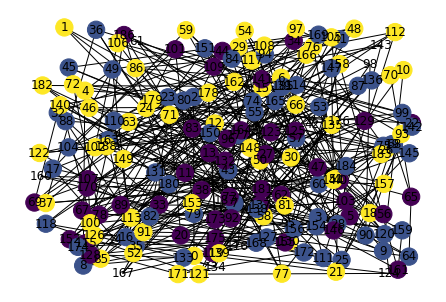

In [32]:
nx.draw(
    graph, 
    pos=getPositions(graph), 
    node_color=[partialColor.get(node) for node in graph.nodes()], 
    with_labels=True, 
    font_color='black'
)

In [38]:
uncoloredNode = nodes[0]
print("the uncolored node %s's neighbors color: " % uncoloredNode)
for i in list(graph.neighbors(uncoloredNode)):
    print('neighbor node %s: ' % i, partialColor.get(i))

the uncolored node 14's neighbors color: 
neighbor node 7:  2
neighbor node 11:  1
neighbor node 12:  5
neighbor node 17:  2


##### The result of partial k coloring shows that 4 color is the optimum solution for this graph.